# How does optimizing Click-Through-Rate actually change a bottom line?

An examination of using Monte Carlo methods to extract statistically significant results from difficult problems.

Z. W. Miller - 2/16/18

## Let's start by importing the stuff we'll need and then checking some version numbers. Note that we're in Python 3 here.

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [3]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3


# Getting started with a matrix

Let's talk about this matrix really quickly. This matrix represents a website for a business. I'll talk about what the numbers mean in the next paragraph, but first let's talk about the designed of the website. The site has a landing home page, a Frequently Asked Questions (FAQ) page, a product page (where it lists the for sale products), and then pages for the two products the business offers. Each product can only be purchased from the product page. Now what do the numbers mean?

Each row lists the connection probability between pages. So in row 0 (our first row) that's the rate of connection to each page coming from the outside internet. So that 0.4 in row 0, column 1 tells us that 40% of the time, people coming from the outside internet land on the home page (since it's ID 1). row 1 is our home page, so we see that in column 0 there's a 40% chance that someone on the home page leaves our website back to the internet at large. In column 2 of row 1, we see that there's a 15% chance that someone on our home page goes to the FAQ page. That's the logic that we have here. The reason the "purchase item 1" only can be connected to by "item 1 page" is that we only allow users to buy an item from one specific page. The "purchase" rows have no connections, because we're going to count that as an end point for now. 

Also, let's be clear up front: I'm making these numbers up for the purposes of demonstrating the technique. It's almost certain that no website anywhere would do as well as I'm about to show you. That said, the technique is the same whether your website does this well or not.

In [46]:
CTR  = [[0., 0.4, 0.2, 0.1, 0.15, 0.15, 0.0, 0.0], # Not our page
        [0.4, 0., 0.15, 0.15, 0.15, 0.15, 0.0, 0.0], # home page
        [0.6, 0.15, 0., 0.25, 0.0, 0.0, 0.0, 0.0], # FAQ
        [0.4, 0.1, 0.05, 0., 0.25, 0.2, 0.0, 0.0], # product page
        [0.4, 0.1, 0.05, 0.1, 0., 0.2, 0.15, 0.], # item 1 page
        [0.4, 0.1, 0.05, 0.1, 0.2, 0., 0., 0.15], # item 2 page
        [0., 0., 0., 0., 0., 0., 0., 0.], # purchase item 1
        [0., 0., 0., 0., 0., 0., 0., 0.]] # purchase item 2

possible_clicks = np.arange(8)
cols = ["Internet", "Home", "FAQ", "Products", "Item 1", "Item 2", "Purchase 1", "Purchase 2"]
df = pd.DataFrame(CTR, columns=cols)
df.index = cols
df

,Internet,Home,FAQ,Products,Item 1,Item 2,Purchase 1,Purchase 2
Internet,0.0,0.40,0.20,0.10,0.15,0.15,0.00,0.00
Home,0.4,0.00,0.15,0.15,0.15,0.15,0.00,0.00
FAQ,0.6,0.15,0.00,0.25,0.00,0.00,0.00,0.00
Products,0.4,0.10,0.05,0.00,0.25,0.20,0.00,0.00
Item 1,0.4,0.10,0.05,0.10,0.00,0.20,0.15,0.00
Item 2,0.4,0.10,0.05,0.10,0.20,0.00,0.00,0.15
Purchase 1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Purchase 2,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Now let's write a function that simulates a user experience. The user will start off in the internet at large. We'll roll a dice to figure out what page they go to, based on the likelihoods that we know from our tracking of the website's analytics.

After the user lands on some page, we'll go to the row for that page, roll a dice to see where they go next. We'll repeat this until they leave the site or purchase something. If they purchase something, we'll return the amount of money we've gained. If they bounce, we'll return no monies.

In [47]:
cost_of_item_1 = 100
cost_of_item_2 = 75

def simulate_user(CTR, debug=False):  
    user_page = 0 # start in the internet at large
    
    while True: # stop if the user is purchasing or leaving
        user_page = np.random.choice(possible_clicks, p=CTR[user_page])
        if debug:
            print(user_page)
        if user_page in [0,6,7]:
            break
    
    if user_page == 6:
        return cost_of_item_1
    elif user_page == 7:
        return cost_of_item_2
    else:
        return 0
    
simulate_user(CTR, debug=True)

4
0


0

Now that we have that ability, let's see how much money we make if we have 10,000 users come in. We'll also track how we're getting our money by seeing how often people purchase each item and how often they bounce.

In [48]:
money = 0.
bounces = 0.
item1_purchases = 0.
item2_purchases = 0.

number_of_users = 10000
for _ in range(number_of_users):
    user_result = simulate_user(CTR)
    money += float(user_result)
    if user_result == cost_of_item_1:
        item1_purchases += 1.
    elif user_result == cost_of_item_2:
        item2_purchases += 1.
    else:
        bounces += 1
        
print("Revenue: ", money)
print("Bounce Rate: ", bounces/number_of_users)
print("Item 1 Purchase Rate: ", item1_purchases/number_of_users)
print("Item 2 Purchase Rate: ", item2_purchases/number_of_users)


Revenue:  96525.0
Bounce Rate:  0.8897
Item 1 Purchase Rate:  0.0552
Item 2 Purchase Rate:  0.0551


That was only one set of 10,000 users. To make sure we're getting a good idea of things (and that we are seeing a statistically relevant output), let's make that into a function and cycle through a bunch of user sets (note, for computational purposes, I'm going to turn it down to 1000 users per cycle)

In [74]:
def measure_revenue(CTR, number_of_users = 10000):
    money = 0.
    bounces = 0.
    item1_purchases = 0.
    item2_purchases = 0.
    
    for _ in range(number_of_users):
        user_result = simulate_user(CTR)
        money += float(user_result)
        if user_result == cost_of_item_1:
            item1_purchases += 1.
        elif user_result == cost_of_item_2:
            item2_purchases += 1.
        else:
            bounces += 1
    return money, bounces, item1_purchases, item2_purchases

track_revenue = []
track_item1 = []
track_item2 = []
track_bounces = []

number_of_user_groups = 1000
number_of_users = 1000
for _ in range(number_of_user_groups):
    money, bounces, item1_purchases, item2_purchases = measure_revenue(CTR, number_of_users=number_of_users)
    track_revenue.append(money)
    track_item1.append(item1_purchases)
    track_item2.append(item2_purchases)
    track_bounces.append(bounces)

Average Revenue/user:  10.28915
Average Bounce Rate:  0.882704
Average Item 1 Purchases:  0.059678
Average Item 2 Purchases:  0.057618


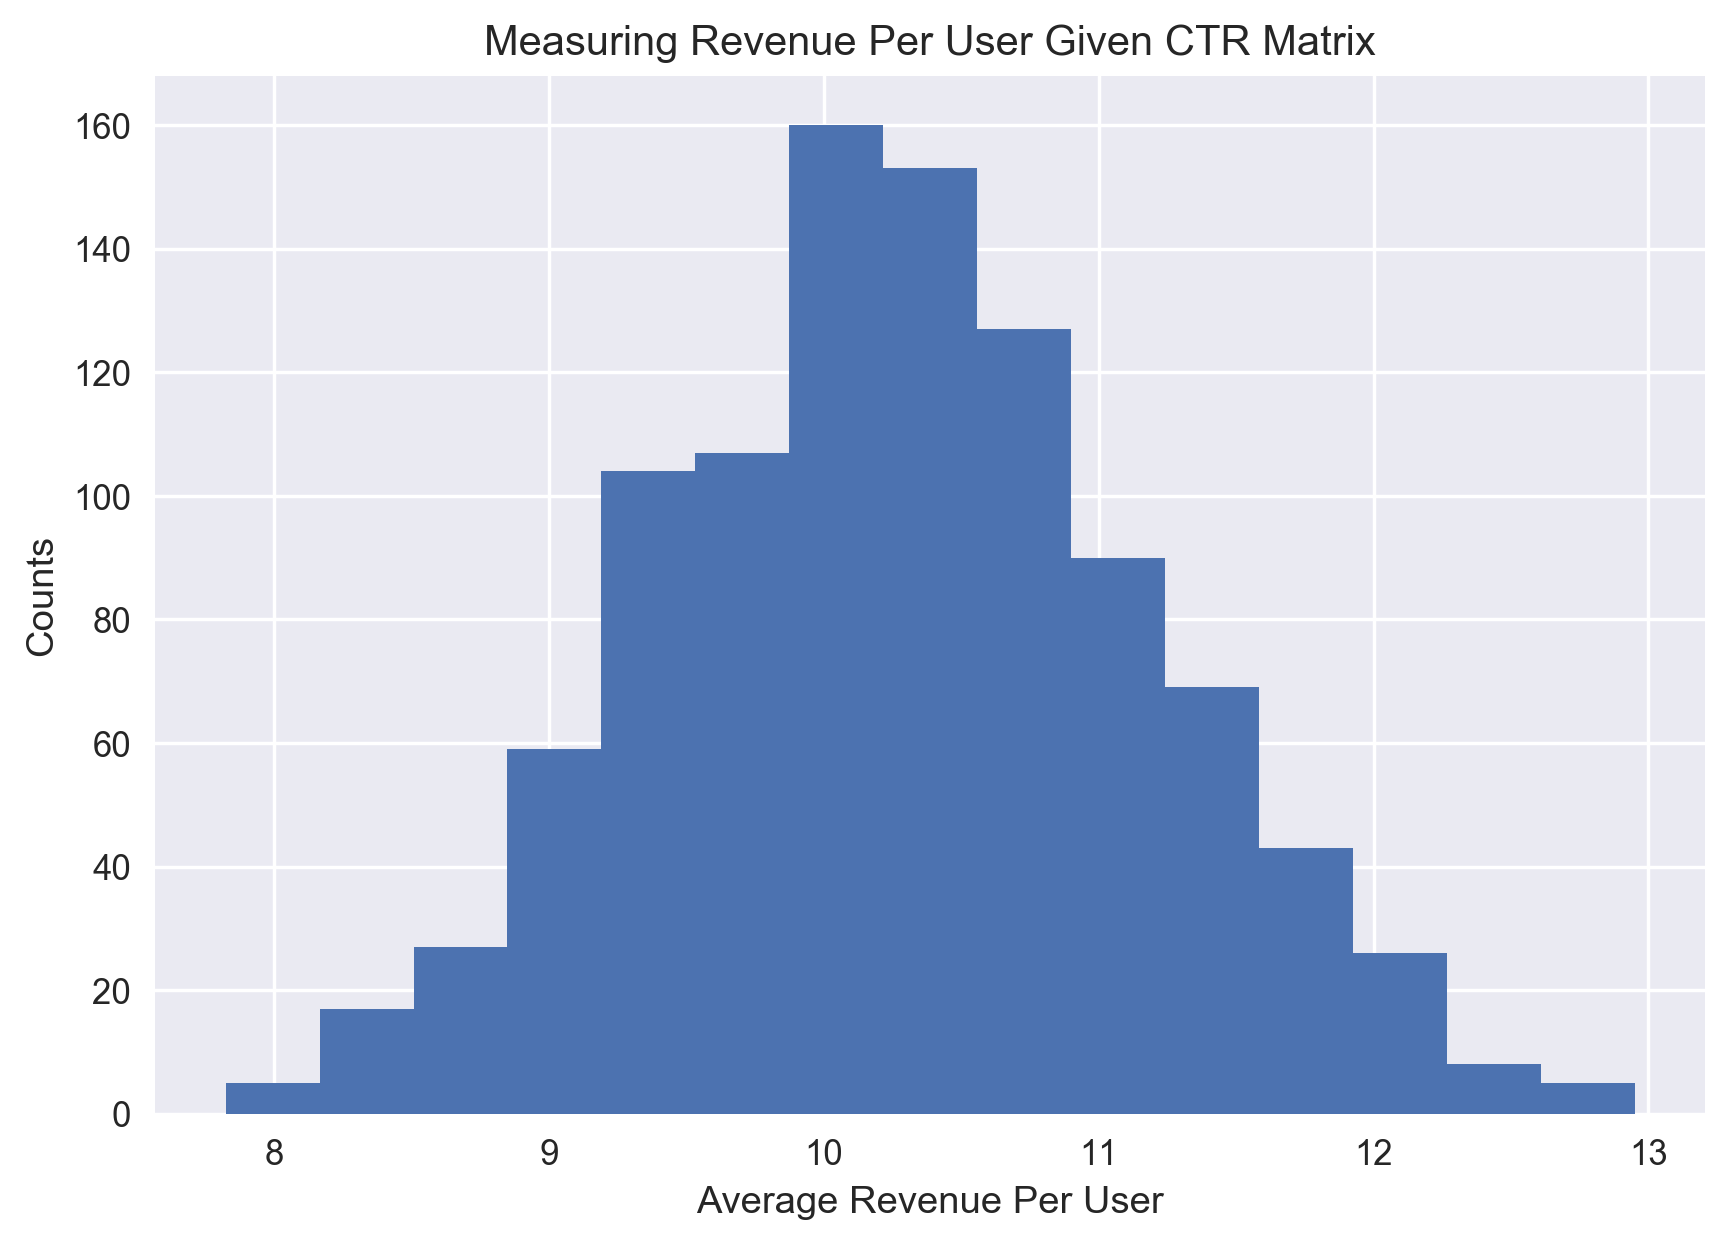

In [75]:
print("Average Revenue/user: ", np.mean(track_revenue)/number_of_users)
print("Average Bounce Rate: ", np.mean(track_bounces)/number_of_users)
print("Average Item 1 Purchases: ", np.mean(track_item1)/number_of_users)
print("Average Item 2 Purchases: ", np.mean(track_item2)/number_of_users)

plt.figure(dpi=250)
plt.hist(np.array(track_revenue)/number_of_users, bins=15);
plt.xlabel("Average Revenue Per User");
plt.ylabel("Counts")
plt.title("Measuring Revenue Per User Given CTR Matrix");

Nice. Given the current design of our website, it looks like roughly 11% of people that come to our page buy something. Which means that our dollars/user is roughly $9.65/user. This would be a good time to re-acknowledge that I'm making these numbers up for the purposes of being demonstrative.

Now let's imagine you go to your marketing team, you hire an analyst that's going to optimize click-through-rate trends, do some A/B testing, and then update your page. Let's even imagine you get a pretty good analyst, and he manages to find some flaws in your FAQ page design. At the end of the day, he finds that he can update your page such that your bounce rate on your FAQ page drops by 10%, and is redistributed to the home page (8%) and your product page (2%). That sounds like a huge move, right? 

A 10% retention gain is uncommonly large for a CTR analysis. But what impact does that have on the bottom line? Well, let's modify our CTR Matrix to account for that, then simulate this again.

In [49]:
CTR2  = [[0., 0.4, 0.2, 0.1, 0.15, 0.15, 0.0, 0.0], # Not our page
        [0.4, 0., 0.15, 0.15, 0.15, 0.15, 0.0, 0.0], # home page
        [0.5, 0.23, 0., 0.27, 0.0, 0.0, 0.0, 0.0], # FAQ
        [0.4, 0.1, 0.05, 0., 0.25, 0.2, 0.0, 0.0], # product page
        [0.4, 0.1, 0.05, 0.1, 0., 0.2, 0.15, 0.], # item 1 page
        [0.4, 0.1, 0.05, 0.1, 0.2, 0., 0., 0.15], # item 2 page
        [0., 0., 0., 0., 0., 0., 0., 0.], # purchase item 1
        [0., 0., 0., 0., 0., 0., 0., 0.]] # purchase item 2

possible_clicks = np.arange(8)
df = pd.DataFrame(CTR, columns=cols)
df.index = cols
df

,Internet,Home,FAQ,Products,Item 1,Item 2,Purchase 1,Purchase 2
Internet,0.0,0.40,0.20,0.10,0.15,0.15,0.00,0.00
Home,0.4,0.00,0.15,0.15,0.15,0.15,0.00,0.00
FAQ,0.6,0.15,0.00,0.25,0.00,0.00,0.00,0.00
Products,0.4,0.10,0.05,0.00,0.25,0.20,0.00,0.00
Item 1,0.4,0.10,0.05,0.10,0.00,0.20,0.15,0.00
Item 2,0.4,0.10,0.05,0.10,0.20,0.00,0.00,0.15
Purchase 1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Purchase 2,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [76]:
track_revenue_2 = []
track_item1_2 = []
track_item2_2 = []
track_bounces_2 = []

number_of_user_groups = 1000
number_of_users = 1000
for _ in range(number_of_user_groups):
    money, bounces, item1_purchases, item2_purchases = measure_revenue(CTR2, number_of_users=number_of_users)
    track_revenue_2.append(money)
    track_item1_2.append(item1_purchases)
    track_item2_2.append(item2_purchases)
    track_bounces_2.append(bounces)

Average Revenue/user:  10.551325
Average Bounce Rate:  0.879809
Average Item 1 Purchases:  0.06148
Average Item 2 Purchases:  0.058711


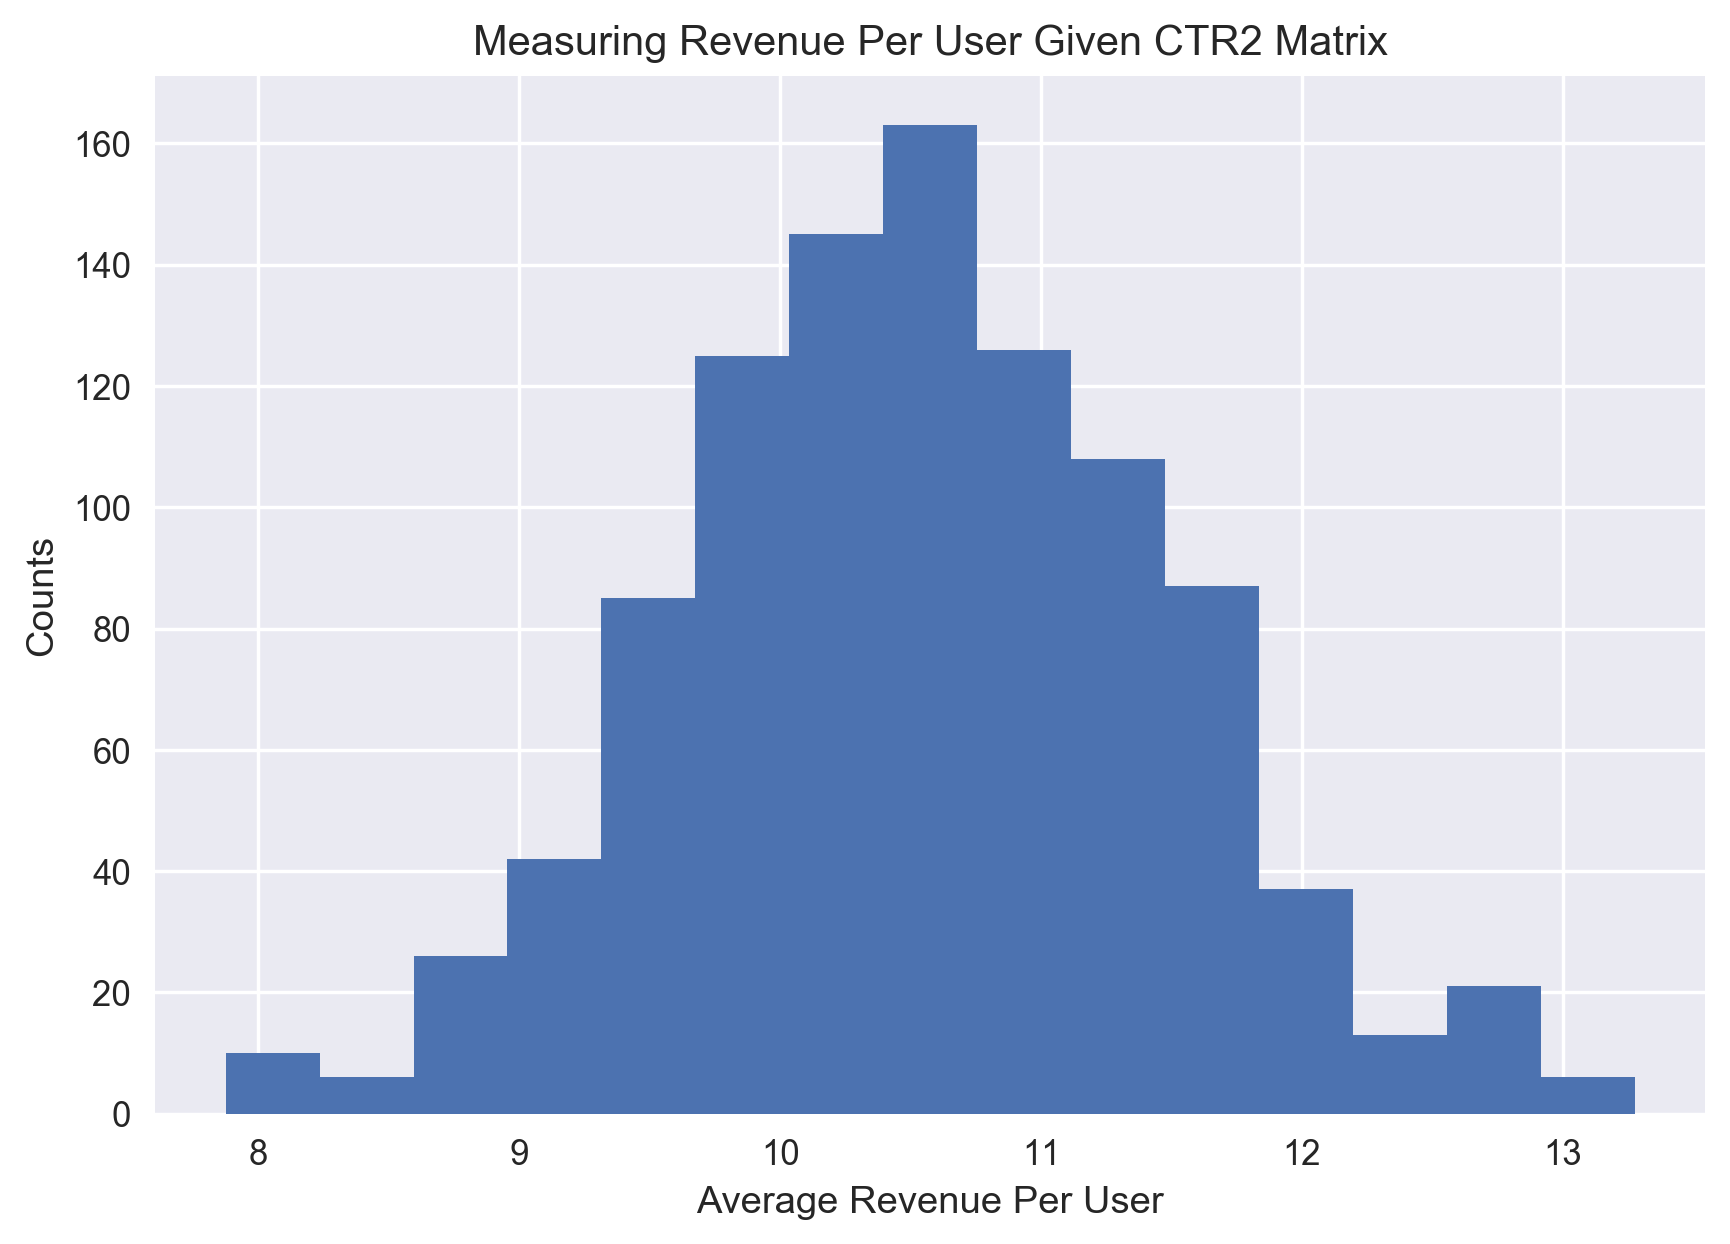

In [77]:
print("Average Revenue/user: ", np.mean(track_revenue_2)/number_of_users)
print("Average Bounce Rate: ", np.mean(track_bounces_2)/number_of_users)
print("Average Item 1 Purchases: ", np.mean(track_item1_2)/number_of_users)
print("Average Item 2 Purchases: ", np.mean(track_item2_2)/number_of_users)

plt.figure(dpi=250)
plt.hist(np.array(track_revenue_2)/number_of_users, bins=15);
plt.xlabel("Average Revenue Per User");
plt.ylabel("Counts")
plt.title("Measuring Revenue Per User Given CTR2 Matrix");

Now let's compare the shift via histogram.

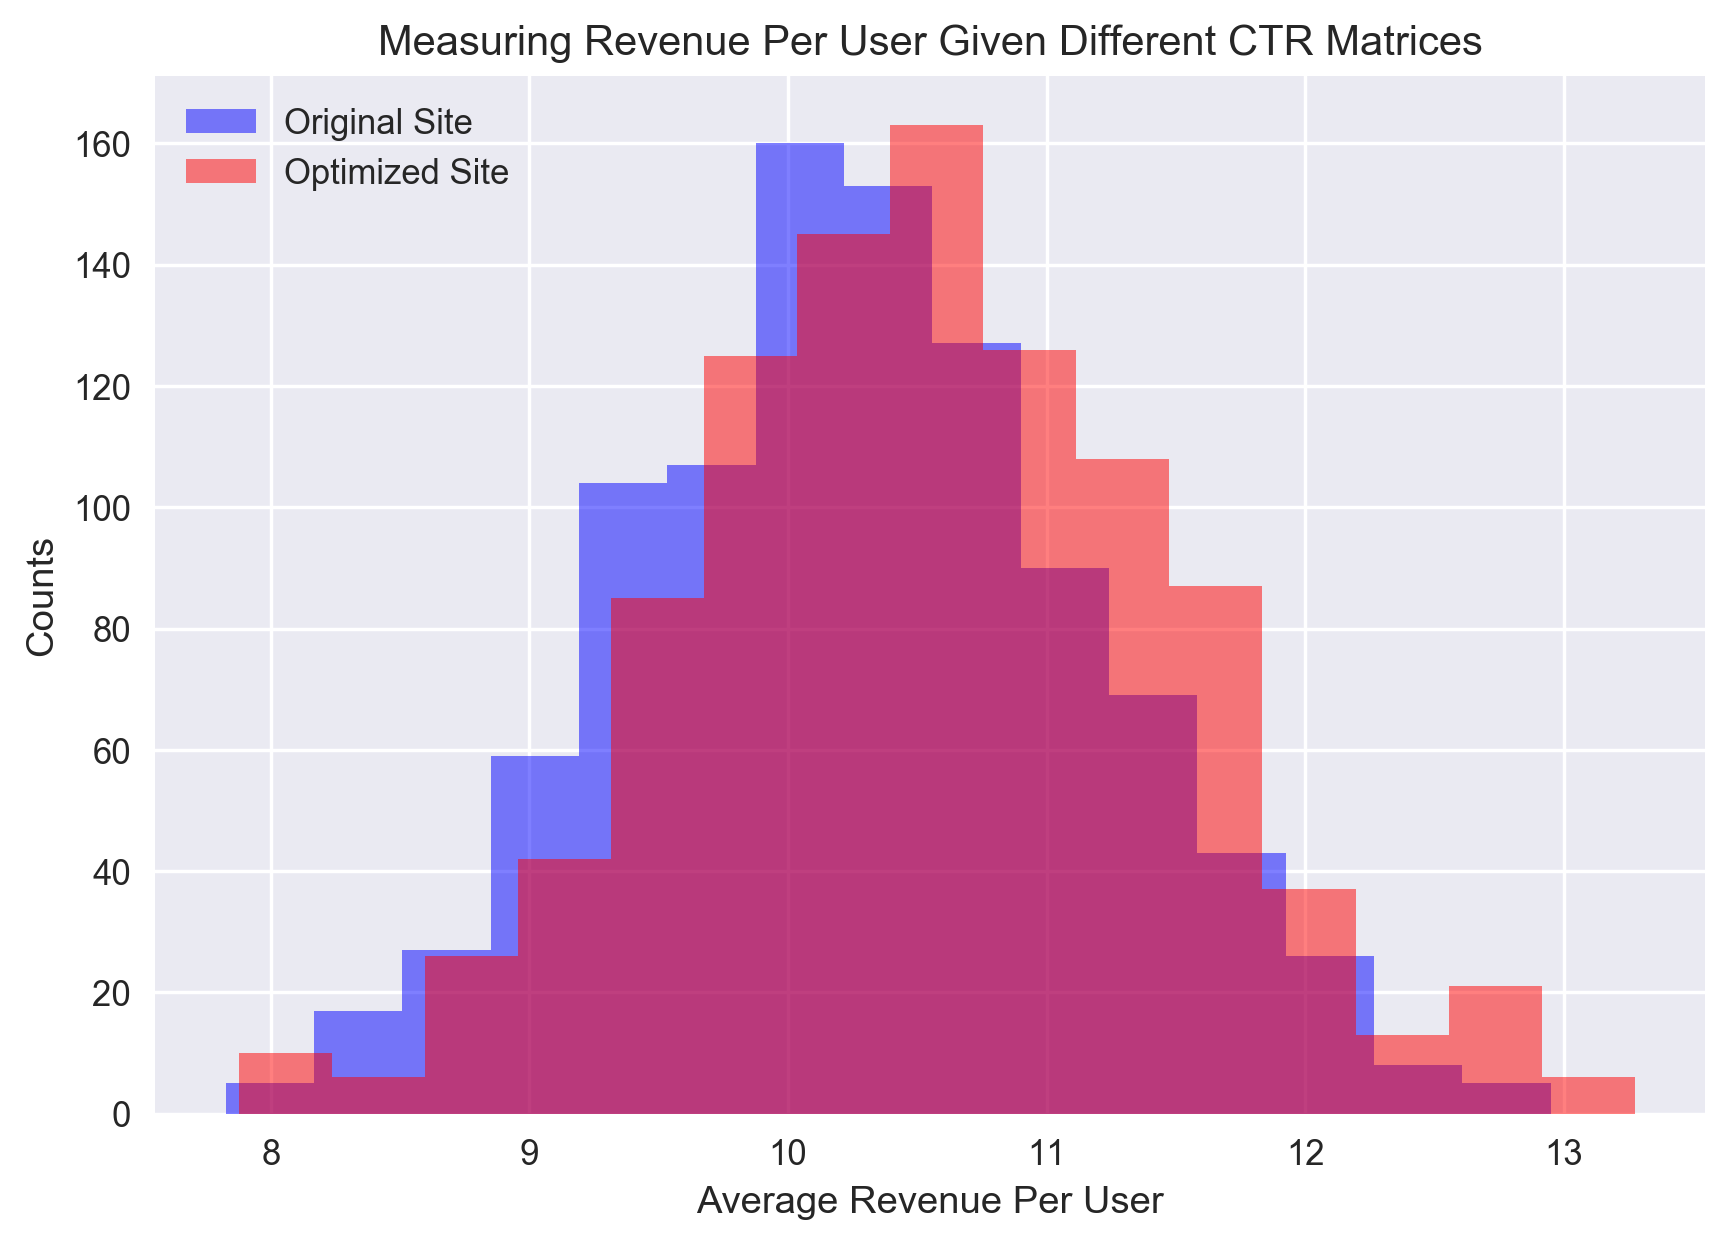

In [79]:
plt.figure(dpi=250)
plt.hist(np.array(track_revenue)/number_of_users, bins=15, color='b', alpha=0.5, label="Original Site");
plt.hist(np.array(track_revenue_2)/number_of_users, bins=15, color='r', alpha=0.5, label="Optimized Site");
plt.xlabel("Average Revenue Per User");
plt.ylabel("Counts")
plt.legend(loc="upper left")
plt.title("Measuring Revenue Per User Given Different CTR Matrices");

In [81]:
(np.mean(track_revenue_2) - np.mean(track_revenue))/np.mean(track_revenue)

0.025480724841216339

To make a final decision on whether this matters or not, we'd need to do significantly more simulations. Right now, the margin of error is so wide, that we can't be 100% certain this is a real effect. For the sake of argument, let's say that the 2% increase is statistically significant... what conclusions can we draw?

We only see about a 2% overall increase in revenue despite seeing a 10% retention rate increase due to our Click-Through optimization. In this case, that 2% is very non-apparent by looking at the situation directly, since the click rates are hard to metnally capture. By using Monte Carlo, we were able to track what that increase did to our bottom-line directly. 

A 2% increase in revenue isn't nothing, but it's a far cry from the 10% increase in CTR. If we had based our measured ROI on just the CTR, we'd have vastly over-estimated the impact on our business. Using MC, we were able to get down to brass tacks and see that the actual ROI is very different, and may not have been worthwhile, depending on cost to analyze and cost to maintain. Also remember that the 10% increase is HUGE for a CTR analysis. This is an example where we have a simple site, a miraculously large increase in CTR, and simple metrics - and even then, we're hard pressed to see a large, business friendly result.